In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torchvision import transforms as tfm
from sklearn import metrics as skmet
import matplotlib.pyplot as plt
import json
import transforms as my_transforms

%aimport dataset
%aimport models
VideoClassifier = models.VideoClassifier
VideoData = dataset.VideoData

In [3]:
artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_no2d_224x224'
# artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_all_224x224'

with open(artifact_folder + '/config_video.json', 'r') as f: 
    cfg = json.load(f)

# put all config variables in scope to avoid the need to laboriously index cfg
for k, v in cfg.items():
    v = f"'{v}'" if type(v)==str else v
    exec(f"{k}={v}")
del cfg

In [4]:
# optionally override the view/mode filters
view_filter = ['pdaView', 'pdaRelatedView']
mode_filter = ['2d', 'color', 'color_compare']

In [5]:
tfms = my_transforms.VideoTransforms(res)
tfms_test = tfms.get_transforms(transforms['test'])

In [6]:
df_test = pd.read_csv(f'{artifact_folder}/{out_paths["test"]}')
d_test = VideoData(df_test, transforms = tfms_test, mode_filter = mode_filter, view_filter = view_filter)
dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers, collate_fn = VideoData.collate)

print("Number of frames after filtering:", len(d_test.data))

Number of frames after filtering: 20948


In [7]:
# create frame model
m_frames = timm.create_model(model, num_classes=num_classes, in_chans=3, drop_rate=dropout)
_ = m_frames.to(device)

# create video model
m = VideoClassifier(m_frames)

# load checkpoint
m.load_state_dict(torch.load(f"{artifact_folder}/model_checkpoint_video.ckpt"))

<All keys matched successfully>

In [8]:
loss_function = torch.functional.F.binary_cross_entropy_with_logits

target_ls = []
output_ls = []
study_ls = []
mask_ls = []
externalid_ls = []
view_ls = []
mode_ls = []
losses = []
attn_ls = []

for ix, batch in enumerate(dl_test):
    print(f"Batch {ix+1}", end = "\r")
    vid = batch['video'].to(device)
    mask = batch['mask'].to(device)
    targets = batch['trg_type'].to(device).type(torch.float32)
    
    target_ls.append(targets.cpu().numpy())
    view_ls.append(batch['trg_view'].numpy())
    mode_ls.append(batch['trg_mode'].numpy())
    study_ls += batch['study']
    mask_ls.append(batch['mask'].numpy())
    externalid_ls += batch['external_id']

    with torch.no_grad():
        outputs, attn = m(vid, mask)
        output_ls.append(outputs.cpu().numpy())
        attn_ls.append(attn.cpu().numpy())
        loss = loss_function(outputs.squeeze(), targets)
        losses.append(loss.detach().item())

In [9]:
df_results = pd.DataFrame(dict(
    study = study_ls,
    external_id = externalid_ls,
    predicted = np.concatenate(output_ls).squeeze(),
    target = np.concatenate(target_ls), 
    mode = np.concatenate(mode_ls),
    view = np.concatenate(view_ls)
))

df_results['mode'] = df_results['mode'].map(VideoData.inv_mode_map)
df_results.view = df_results.view.map(VideoData.inv_view_map)

df_results.head(20)

,study,external_id,predicted,target,mode,view
0,study57,study57_dicom87,0.105263,0.0,2d,pdaRelatedView
1,study57,study57_dicom91,0.097739,0.0,2d,pdaView
2,study57,study57_dicom61,0.210324,0.0,color,pdaView
3,study57,study57_dicom88,0.146953,0.0,color,pdaRelatedView
4,study57,study57_dicom86,0.136008,0.0,2d,pdaRelatedView
5,study57,study57_dicom101,0.308916,0.0,color,pdaRelatedView
6,study16,study16_dicom15,0.251454,1.0,2d,pdaRelatedView
7,study16,study16_dicom16,0.992088,1.0,color,pdaRelatedView
8,study16,study16_dicom17,0.330372,1.0,2d,pdaView
9,study16,study16_dicom18,0.998570,1.0,color,pdaView


In [10]:
def compute_metrics(y_true, y_pred, thresh=0.5):
    mets = dict()
    
    y_pred_cls = (y_pred>thresh).astype(int)
    
    mets['num_samples'] = len(y_true)
    mets['roc_auc'] = skmet.roc_auc_score(y_true, y_pred)
    mets['average_precision'] = skmet.average_precision_score(y_true, y_pred)
    mets['accuracy'] = skmet.accuracy_score(y_true, y_pred_cls)
    mets['sensitivity'] = skmet.recall_score(y_true, y_pred_cls)
    mets['specificity'] = skmet.recall_score(y_true, y_pred_cls, pos_label=0)
    
    return mets

# Clip-level results

In [11]:
compute_metrics(df_results.target, df_results.predicted)

{'num_samples': 226,
 'roc_auc': 0.751058898745305,
 'average_precision': 0.847008993350558,
 'accuracy': 0.7079646017699115,
 'sensitivity': 0.6201550387596899,
 'specificity': 0.8247422680412371}

In [12]:
grouped_results = df_results.groupby(['view', 'mode']).apply(lambda dat: compute_metrics(dat.target, dat.predicted))
grouped_results = pd.DataFrame(grouped_results.tolist(), index=grouped_results.index)
grouped_results

num_samples   roc_auc  average_precision  \
view           mode                                                      
pdaRelatedView 2d                      58  0.551515           0.645350   
               color                   54  0.944444           0.902372   
               color_compare           27  0.929412           0.954822   
pdaView        2d                      26  0.648810           0.659708   
               color                   24  0.964286           0.976053   
               color_compare           37  0.974074           0.991417   

                              accuracy  sensitivity  specificity  
view           mode                                               
pdaRelatedView 2d             0.431034     0.060606         0.92  
               color          0.833333     1.000000         0.70  
               color_compare  0.851852     0.823529         0.90  
pdaView        2d             0.461538     0.000000         1.00  
               color          0.833333     1.000000         0.60  
               color_compare  0.945946     0.962963         0.90

# Attention

In [28]:
df_results.query('target==0.0 and mode=="color" and view=="pdaView"')

,study,external_id,predicted,target,mode,view
2,study57,study57_dicom61,0.210324,0.0,color,pdaView
10,study44,study44_dicom92,0.201490,0.0,color,pdaView
15,study44,study44_dicom56,0.417622,0.0,color,pdaView
17,study56,study56_dicom52,0.573524,0.0,color,pdaView
71,study48,study48_dicom74,0.644023,0.0,color,pdaView
72,study48,study48_dicom52,0.806223,0.0,color,pdaView
128,study64,study64_dicom2,0.738451,0.0,color,pdaView
138,study72,study72_dicom65,0.194547,0.0,color,pdaView
148,study37,study37_dicom96,0.494322,0.0,color,pdaView
152,study37,study37_dicom84,0.094143,0.0,color,pdaView


In [32]:
index = 10
batch_ix = index // bs_test
ix_in_batch = index % bs_test

mask = mask_ls[batch_ix][...,ix_in_batch]
attn = attn_ls[batch_ix][...,ix_in_batch]
trg_type = int(target_ls[batch_ix][ix_in_batch])
target = VideoData.inv_type_map[trg_type]
view = VideoData.inv_view_map[int(view_ls[batch_ix][ix_in_batch])]
external_id = externalid_ls[index]

mp4_path = df_test.loc[(df_test.external_id == external_id) & (df_test.trg_type == trg_type)].mp4_path.unique().item()
mp4_path = mp4_path.replace('/Superior Views/', '/superior_views_h264/')

print(external_id, target, view, sep=' - ')

study44_dicom92 - nopda - pdaView


(0.0, 0.1)

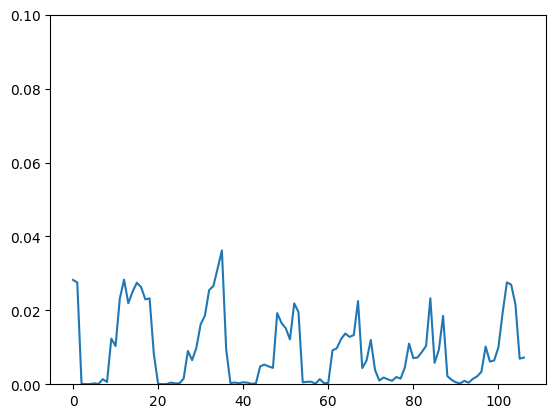

In [33]:
plt.plot(attn[mask])
plt.ylim(0,0.1)

In [34]:
# from IPython.display import FileLink
# !cp $mp4_path /home/dane2/Code/pda_detection/